This notebook contains a simple image classification model using the [MNIST](http://yann.lecun.com/exdb/mnist/) data. <br>

In [43]:
from keras.datasets import mnist
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Dropout, Flatten, Dense, Convolution2D, MaxPooling2D
from keras.utils import np_utils, data_utils, visualize_util
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import json
from PIL import Image
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [5]:
## Some model and data processing constants

batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel sizeb
nb_conv = 3

## Load the MNIST data

In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
y_train.shape

(60000,)

In [7]:
y_test.shape

(10000,)

## Explore the dataset

### Training images

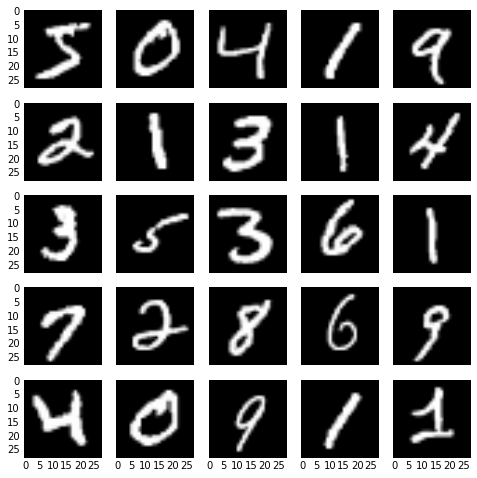

In [37]:
fig, axes = plt.subplots(5, 5, figsize=(8,8), sharex=True, sharey=True)
for id, ax in enumerate(axes.ravel()):
    image = Image.fromarray(X_train[id, :, :])
    ax.imshow(image, cmap='Greys_r')

### Targets (train and test) distributions

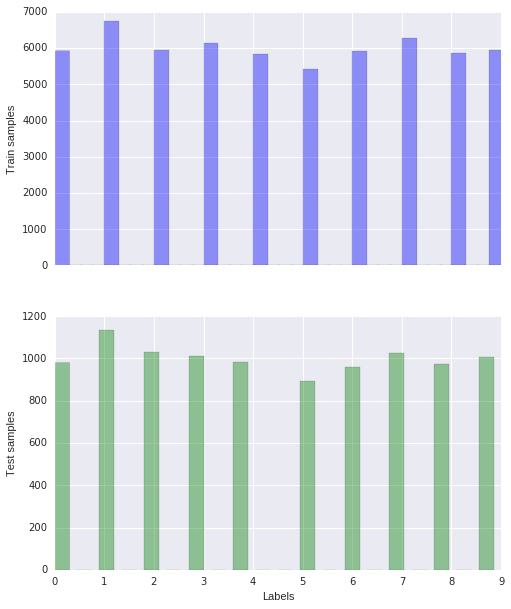

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
sns.distplot(y_train, kde=False, ax=ax1, color='blue', hist_kws={"width": 0.3, "align": "mid"})
ax1.set_ylabel('Train samples')
sns.distplot(y_test, kde=False, ax=ax2, color='green', hist_kws={"width": 0.3, "align": "mid"})
ax2.set_ylabel('Test samples')
ax2.set_xlabel('Labels')

## Our first multiclass classification neural network
This is a model that is mostly inspired from here: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py 

### Data processing 

In [16]:
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


### Model definiton

In [13]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

### Model architecture

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 32, 26, 26)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 24, 24)    9248        activation_3[0][0]               
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 32, 24, 24)    0           convolution2d_4[0][0]            
___________________________________________________________________________________________

### Visualize the model 

In [40]:
visualize_util.plot(loaded_model, 
                    to_file='simple_image_classification_architecture.png', show_shapes=True)

### Model training and evaluation

In [16]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 240s - loss: 0.3923 - acc: 0.8800 - val_loss: 0.0975 - val_acc: 0.9691
Epoch 2/12
60000/60000 [==============================] - 240s - loss: 0.1455 - acc: 0.9569 - val_loss: 0.0631 - val_acc: 0.9804
Epoch 3/12
60000/60000 [==============================] - 245s - loss: 0.1096 - acc: 0.9673 - val_loss: 0.0531 - val_acc: 0.9825
Epoch 4/12
60000/60000 [==============================] - 247s - loss: 0.0921 - acc: 0.9723 - val_loss: 0.0450 - val_acc: 0.9849
Epoch 5/12
60000/60000 [==============================] - 256s - loss: 0.0814 - acc: 0.9758 - val_loss: 0.0407 - val_acc: 0.9864
Epoch 6/12
60000/60000 [==============================] - 251s - loss: 0.0724 - acc: 0.9787 - val_loss: 0.0363 - val_acc: 0.9876
Epoch 7/12
60000/60000 [==============================] - 252s - loss: 0.0671 - acc: 0.9798 - val_loss: 0.0342 - val_acc: 0.9886
Epoch 8/12
60000/60000 [=======================

### Save the model and load it if necessary

#### Save the model weights

In [29]:
model.save_weights('simple_image_classification_weights.h5')

#### Save the model architecture

In [30]:
saved_model = model.to_json()
with open('simple_image_classification_architecture.json', 'w') as outfile:
    json.dump(saved_model, outfile)

#### Load the model (architecture and weights)

In [9]:
### Load architecture
with open('simple_image_classification_architecture.json', 'r') as architecture_file:    
    model_architecture = json.load(architecture_file)


loaded_model = model_from_json(model_architecture)

In [11]:
### Load weights
loaded_model.load_weights('simple_image_classification_weights.h5')

### Model predictions (predicted classes)

In [21]:
predictions = model.predict_classes(X_test)

10000/10000 [==============================] - 15s    


In [41]:
(predictions == y_test).sum() / len(predictions)

0.98970000000000002

### Make prediction on an unseen image

In [26]:
X_test_example = X_test[0, :, : ,:].reshape(1, 1, img_rows, img_cols)

In [ ]:
hand_written_digit = 

In [ ]:
X_test_example.

In [27]:
loaded_model.predict(X_test_example)

array([[  4.94275766e-11,   4.65901373e-10,   7.93653765e-09,
          1.65167329e-08,   1.39302311e-11,   2.24871640e-12,
          7.70147502e-16,   9.99999940e-01,   5.06304894e-12,
          7.78836196e-09]])

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')